In [38]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

import matplotlib.pyplot as plt
import seaborn as sns

In [39]:
def plot_dbscan(dbscan, X, size):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]
    
    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20, c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], marker=".")
    plt.title("eps={:.2f}, min_samples={}".format(dbscan.eps, dbscan.min_samples), fontsize=14)

In [40]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=3, linewidths=8,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(klasyfikator, X):
    # wyznaczanie granic decyzyjnych, podobnie jak w poprzednich notatnikach
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], 100),
                         np.linspace(mins[1], maxs[1], 100))
    Z = klasyfikator.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # rysowanie konturów granic 
    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    
    # rysowanie danych
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    # centra klastrów można wyciągnąc za pomocą zmiennej cluster_centers_
    plot_centroids(klasyfikator.cluster_centers_)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

In [41]:
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt

# metoda zaporzyczona z przykładów sklearn oraz lekko zmodyfikowana zmodyfikowana 
def plot_gaussian_mixture(clf, X, resolution=1000):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clf.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, linewidths=3, colors='b')
    
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

    plt.xlabel("$x_1$", fontsize=14)
    plt.tick_params(labelleft=False)

<Axes: xlabel='x1', ylabel='x2'>

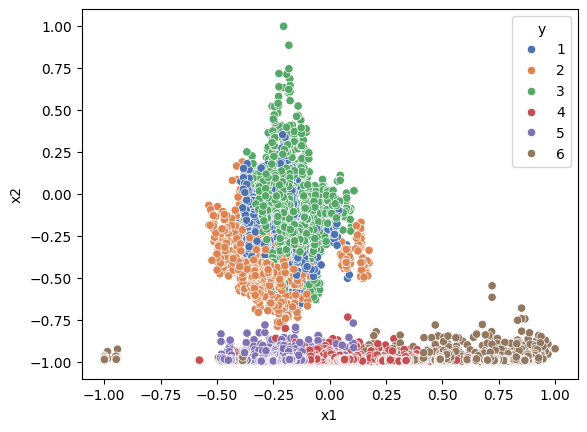

In [42]:
X_train = pd.read_csv('samsung_train.txt', header=None, delim_whitespace=True)
X_test  = pd.read_csv('samsung_test.txt', header=None, delim_whitespace=True)
X       = pd.concat([X_train, X_test], ignore_index=True)
X1 = X[[50,95]]

y_train = pd.read_csv('samsung_train_labels.txt', header=None, delim_whitespace=True)
y_test  = pd.read_csv('samsung_test_labels.txt', header=None, delim_whitespace=True)
y1       = pd.concat([y_train, y_test], ignore_index=True)


do_wykresu = pd.concat([X1, y1],axis=1,ignore_index=False)
do_wykresu.columns = ['x1', 'x2', 'y']
sns.scatterplot(data=do_wykresu, x="x1", y="x2", hue='y', palette="deep")

In [43]:
X_train = pd.read_csv('samsung_train.txt', header=None, delim_whitespace=True)
X_test  = pd.read_csv('samsung_test.txt', header=None, delim_whitespace=True)
X       = pd.concat([X_train , X_test], ignore_index=True)
X = X[[50,95]]
X = X.to_numpy()

y_train = pd.read_csv('samsung_train_labels.txt', header=None, delim_whitespace=True)
y_test  = pd.read_csv('samsung_test_labels.txt', header=None, delim_whitespace=True)
y       = pd.concat([y_train , y_test], ignore_index=True)
y = y.to_numpy()



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)


In [44]:
sgdc_clf = SGDClassifier(random_state=1)
svm_clf = SVC()
log_reg_clf = LogisticRegression(multi_class="ovr", max_iter=5000, random_state=2)

sgdc_clf.fit(X_train, y_train)
sgdc_score = sgdc_clf.score(X_test, y_test)
print("Pojedynczy wynik dla SGDC: ", sgdc_score)

svm_clf.fit(X_train, y_train)
svm_score = svm_clf.score(X_test, y_test)
print("Pojedynczy wynik dla SVM: ", svm_score)

log_reg_clf.fit(X_train, y_train)
log_reg_score = log_reg_clf.score(X_test, y_test)
print("Pojedynczy wynik dla LogisticRegression: ", log_reg_score)

Pojedynczy wynik dla SGDC:  0.6587378640776699
Pojedynczy wynik dla SVM:  0.7364077669902913
Pojedynczy wynik dla LogisticRegression:  0.7009708737864078


In [45]:
# stworzenie KFold obiektu z 5 foldami i tasowaniem danych
kf = KFold(n_splits=5, shuffle=True, random_state=1)

scaler = StandardScaler()
models = []
scores = []

for fold_nr, (train_idx, test_idx) in enumerate(kf.split(X)):
  X_train = X[train_idx]
  X_test =X[test_idx]

  y_train = y[train_idx]
  y_test = y[test_idx]

  # skalowanie danych wejściowych, aby model lepiej działał
  X_train = scaler.fit_transform(X_train)
  X_test = scaler.transform(X_test)

  clf = SGDClassifier(random_state=1).fit(X_train, y_train)

  models.append(clf)
  scores.append(clf.score(X_test, y_test))


print("wyniki poszczególnych foldów: ", scores)
print("średni wynik wszystkich foldów: ", np.array(scores).mean())

wyniki poszczególnych foldów:  [0.6490291262135922, 0.6529126213592233, 0.6713592233009709, 0.5927184466019417, 0.6430305973773677]
średni wynik wszystkich foldów:  0.6418100029706191


In [46]:
# stworzenie klasyfikatora
clf = SGDClassifier(random_state=1)

# użycie metody cross_val_score do sprawdzenia
# działania naszego modelu na różnych podziałach
cv_score = cross_val_score(clf, X, y, cv=5)
print("wynik kroswalidacji: ", cv_score)
print("średni wynik wszystkich foldów: ", cv_score.mean())

wynik kroswalidacji:  [0.63252427 0.60145631 0.59417476 0.62427184 0.6002914 ]
średni wynik wszystkich foldów:  0.6105437176119994


In [47]:
# wcześniejszy przykład z użyciem stratifiedKFold

from sklearn.model_selection import StratifiedKFold


# stworzenie KFold obiektu z 5 foldami i tasowaniem danych
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

models = []
scores = []

# iteracja przez poszczególne foldy
for fold_nr, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    X_train = X[train_idx]
    X_test =X[test_idx]

    y_train = y[train_idx]
    y_test = y[test_idx]

    # skalowanie danych wewnątrz poszczeŋólnych iteracji
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
  
    # stworzenie klasyfikatora dla poszczególnej iteracji
    # wytrenowanie klasyfikatora na danych treningowych
    clf = SGDClassifier(random_state=1).fit(X_train, y_train)

    # dodawanie klasyfikatora do tablicy klasyfikatorów
    models.append(clf)
    # dodawanie wyniku dla danych testowych do tablicy
    scores.append(clf.score(X_test, y_test))


print("wyniki poszczególnych foldów: ", scores)
print("średni wynik wszystkich foldów: ", np.array(scores).mean())

wyniki poszczególnych foldów:  [0.6063106796116505, 0.5519417475728156, 0.5621359223300971, 0.6315533980582524, 0.6401165614375911]
średni wynik wszystkich foldów:  0.5984116618020814


In [48]:
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size = 0.2, random_state=3)

train_0, train_1 = len(y_train[y_train==0]), len(y_train[y_train==1])
test_0, test_1 = len(y_test[y_test==0]), len(y_test[y_test==1])

print('>Train: 0=%d, 1=%d, Test: 0=%d, 1=%d' % (train_0, train_1, test_0, test_1))

>Train: 0=0, 1=1371, Test: 0=0, 1=351


In [49]:
from sklearn.cluster import KMeans

clf = KMeans(n_clusters=5)

y_pred = clf.fit_predict(X)
y_pred

array([0, 0, 0, ..., 1, 1, 1])

In [50]:
clf_1 = KMeans(n_clusters=5, max_iter=1, init="random", n_init=1, algorithm="lloyd", random_state=42)
clf_2 = KMeans(n_clusters=5, max_iter=2, init="random", n_init=1, algorithm="lloyd", random_state=42)
clf_3 = KMeans(n_clusters=5, max_iter=3, init="random", n_init=1, algorithm="lloyd", random_state=42)
clf_300 = KMeans(n_clusters=5, max_iter=300, init="random", n_init=1, algorithm="lloyd", random_state=42)
clf_1.fit(X)
clf_2.fit(X)
clf_3.fit(X)
clf_300.fit(X)

KMeans(init='random', n_clusters=5, n_init=1, random_state=42)

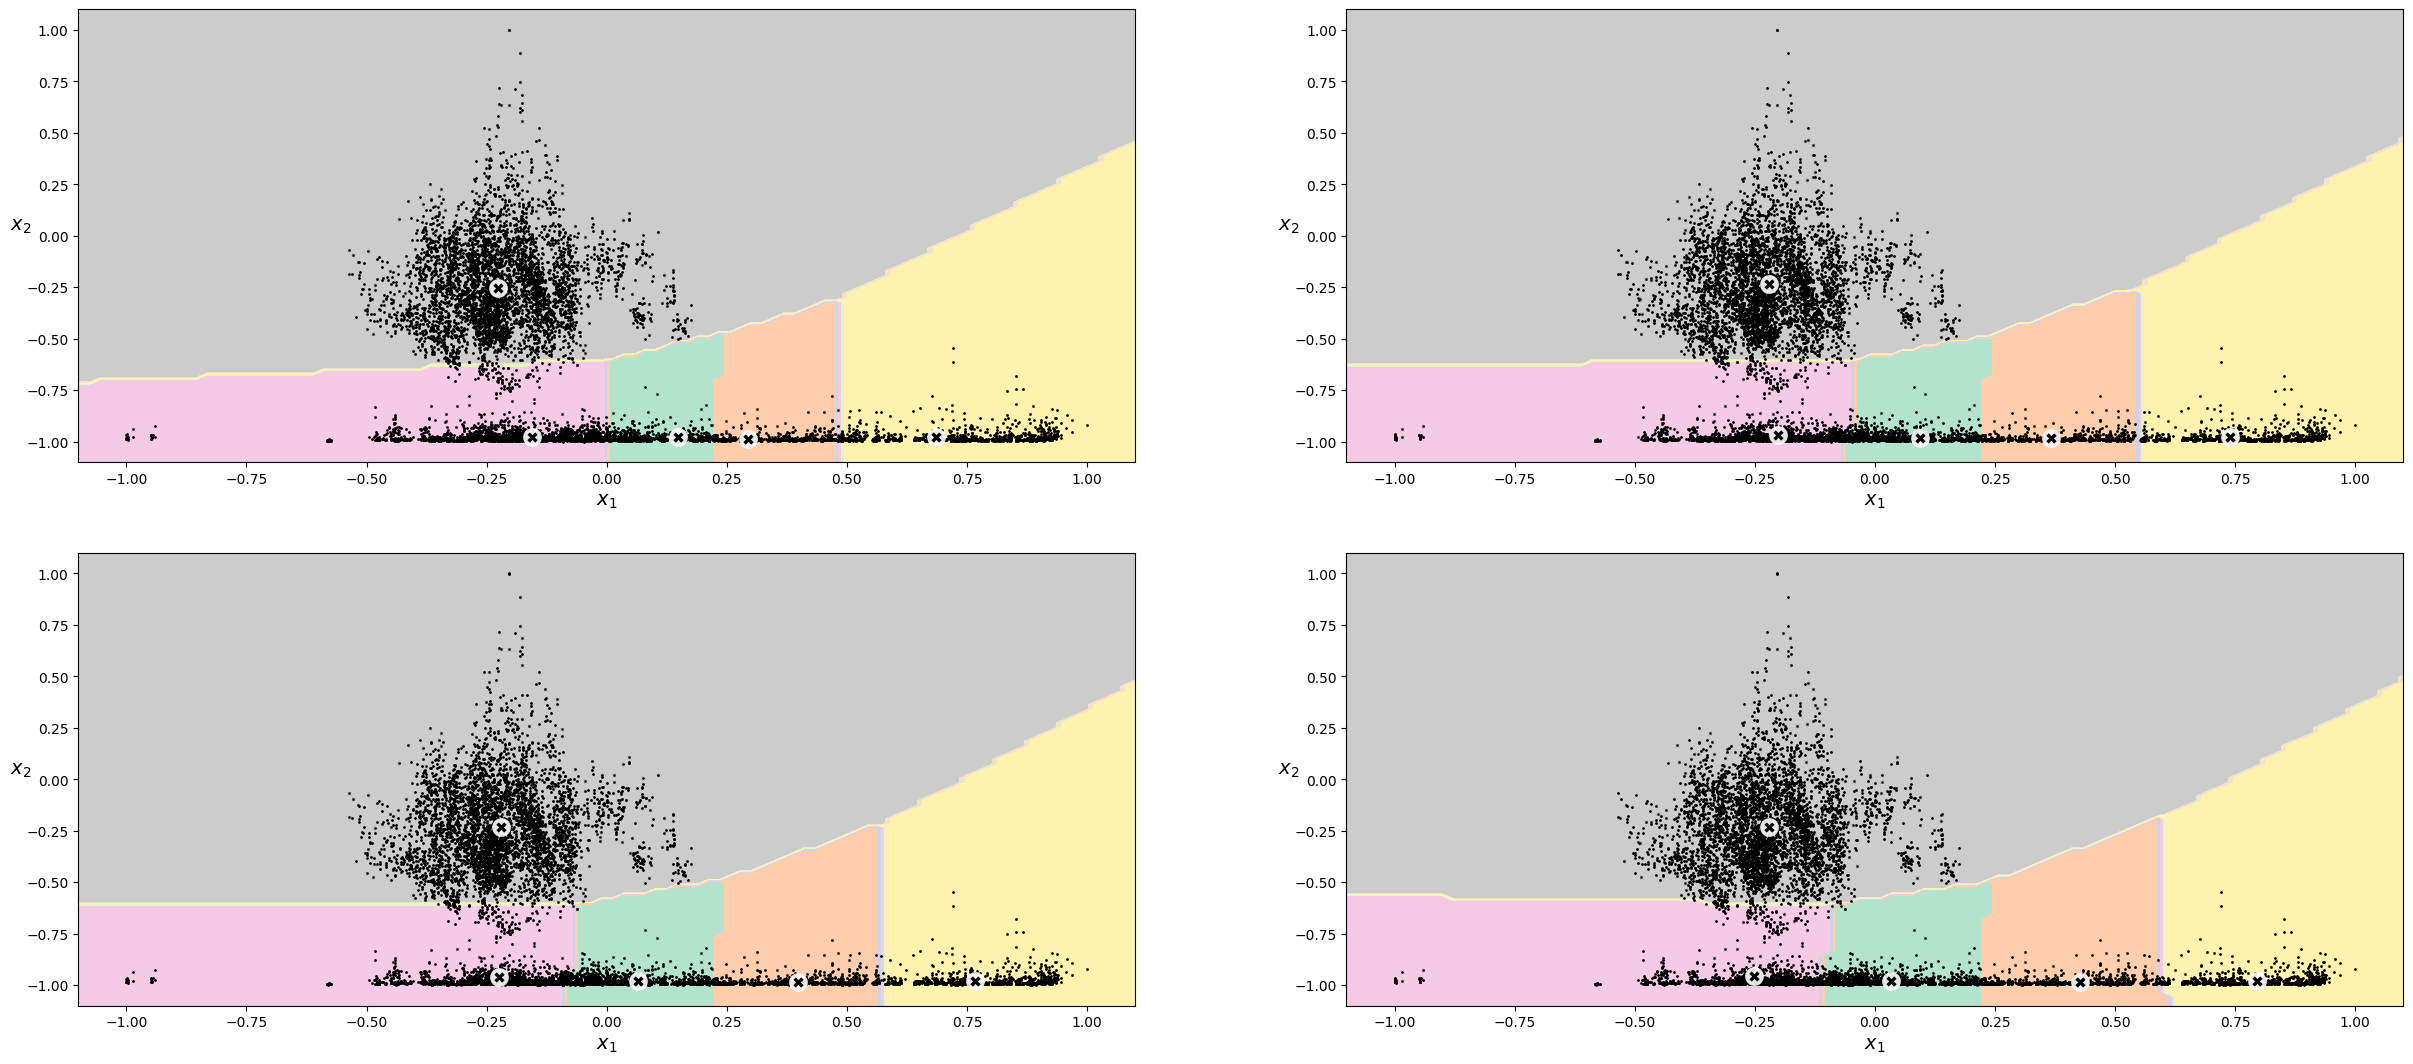

In [51]:
# narysujmy teraz poszczególne kroki jeden pod drugim

plt.figure(figsize=(30, 20))

plt.subplot(321)
plot_decision_boundaries(clf_1, X)

plt.subplot(322)
plot_decision_boundaries(clf_2, X)

plt.subplot(323)
plot_decision_boundaries(clf_3, X)

plt.subplot(324)
plot_decision_boundaries(clf_300, X)
plt.show()

In [52]:
%timeit

# metoda KMeans
KMeans_clf = KMeans(n_clusters=5, max_iter=10, random_state=1)
KMeans_clf.fit(X)

KMeans(max_iter=10, n_clusters=5, random_state=1)

In [53]:
# tworzymy 19 algorytmów z k od 1 do 19
kmeans_per_k = [
    KMeans(n_clusters=k, random_state=2).fit(X)
    for k in range(2, 20) # zaczynamy od wartości n_clusters wynoszącej 2, gdyż nie ma sensu dzielenia zbioru dla 1 klastra
]

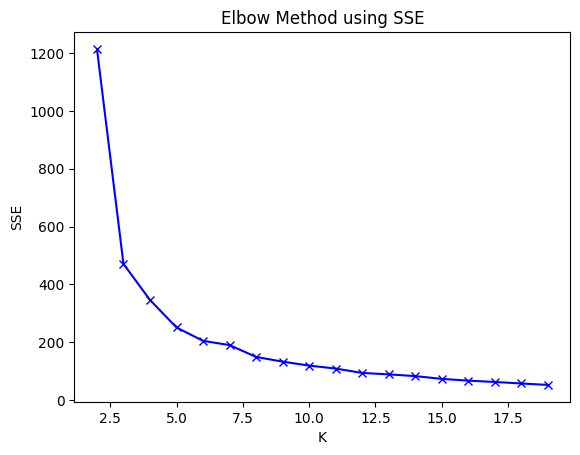

In [54]:
inertias = [model.inertia_ for model in kmeans_per_k]
plt.plot(range(2, 20), inertias, 'bx-')
plt.xlabel('K')
plt.ylabel('SSE')
plt.title('Elbow Method using SSE')
plt.show()

In [55]:
# 1. Tworzymy tablicę klasyfikatorów z różnym K i szkolimy ją na zbiorze
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(1, 10)]

silhouette_scores = [
    silhouette_score(X, y)
    for model in kmeans_per_k
]

#2. Używamy tzw silhouette_score

silhouette_scores = [
    silhouette_score(X, model.labels_)
    for model in kmeans_per_k[1:]
]

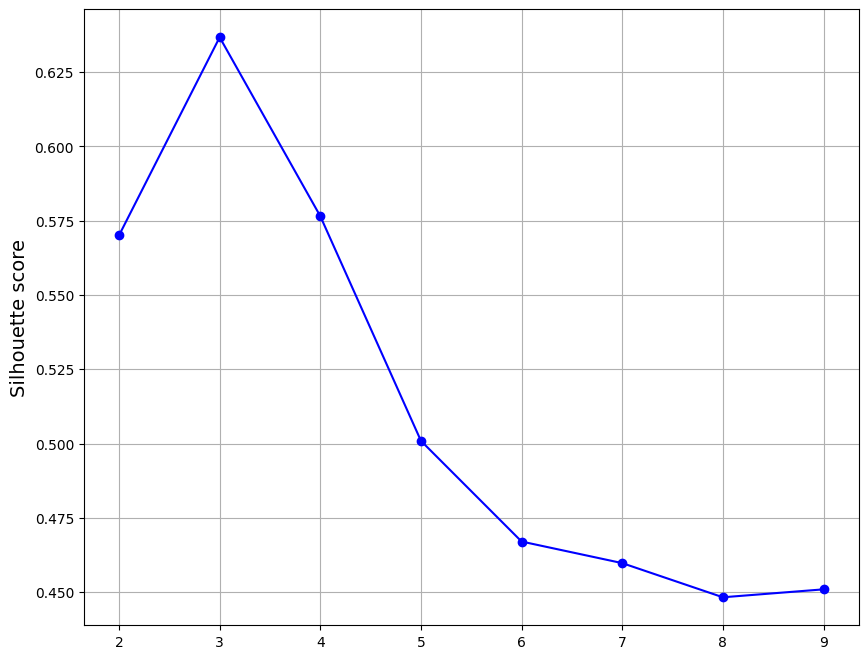

In [56]:
plt.figure(figsize=(10, 8))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.ylabel("Silhouette score", fontsize=14)
plt.grid()
plt.show()

In [57]:
log_reg = LogisticRegression(multi_class="ovr", max_iter=5000, random_state=2)
log_reg.fit(X_train, y_train)

print("Bez KMeans :", log_reg.score(X_test, y_test))

pipeline = Pipeline([
    ("kmeans", KMeans(
        n_clusters=40,
        random_state=2
    )),
    ("log_reg", LogisticRegression(
        multi_class="ovr",
        max_iter=5000,
        random_state=2
    )),
])
pipeline.fit(X_train, y_train)

print("Z KMeans :", pipeline.score(X_test, y_test))

Bez KMeans : 0.695631067961165
Z KMeans : 0.7266990291262136


In [58]:
# tworzymy pierwszy klasyfikator DBSCAN z eps = 0.05
dbscan = DBSCAN(eps=0.05, min_samples=5)
dbscan.fit(X)

# drugi DBSCAN z eps = 0.2 (większy epsilon, większa przestrzeń wokół)
dbscan_2 = DBSCAN(eps=0.2, min_samples=5)
dbscan_2.fit(X)

DBSCAN(eps=0.2)

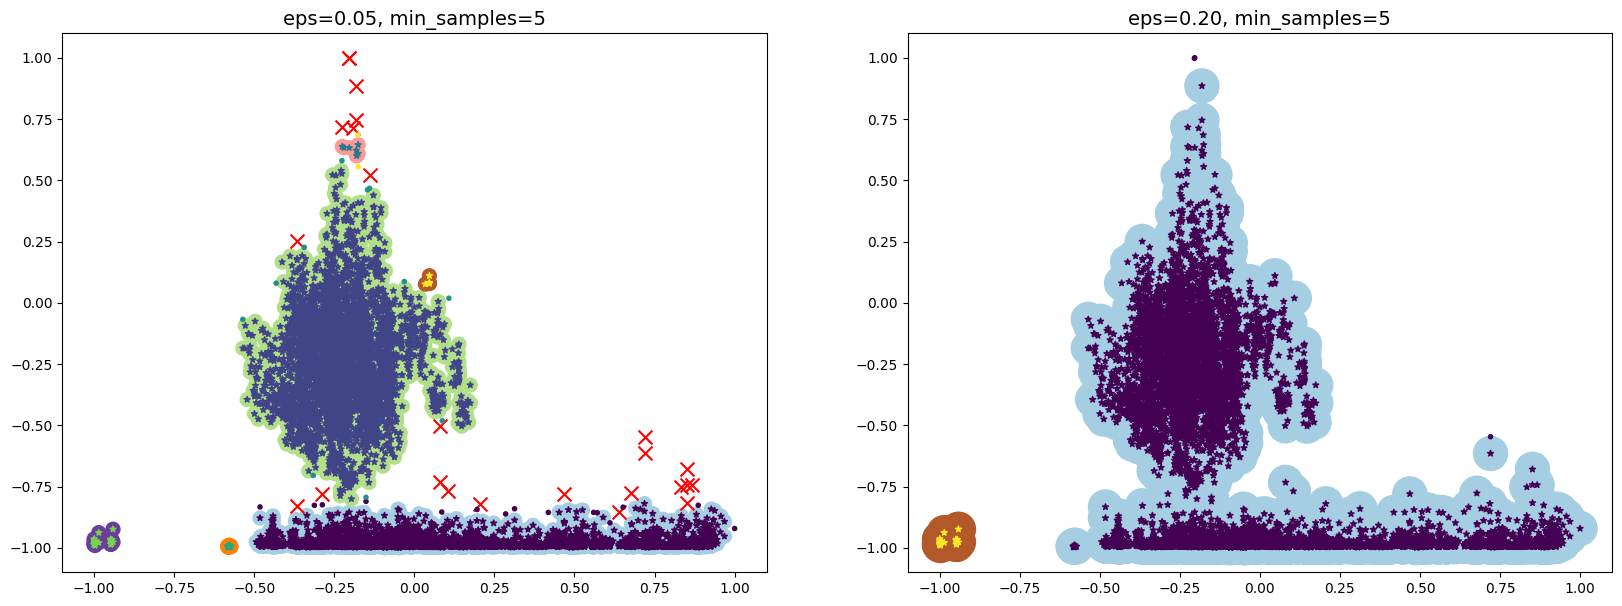

In [59]:
plt.figure(figsize=(20, 7))

plt.subplot(121)
plot_dbscan(dbscan, X, size=100)

plt.subplot(122)
plot_dbscan(dbscan_2, X, size=600)

plt.show()

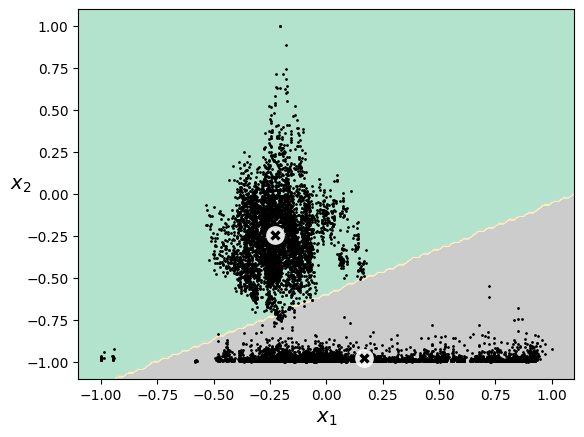

In [60]:
KMeans_clf = KMeans(n_clusters=2, max_iter=100000)
KMeans_clf.fit(X)

plot_decision_boundaries(KMeans_clf, X)

In [61]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=3, n_init=10, random_state=42, covariance_type="tied")
gm.fit(X)

gm_2 = GaussianMixture(n_components=3, n_init=10, random_state=42, covariance_type="full")
gm_2.fit(X)

gm_3 = GaussianMixture(n_components=3, n_init=10, random_state=42, covariance_type="diag")
gm_3.fit(X)

gm_4 = GaussianMixture(n_components=3, n_init=10, random_state=42, covariance_type="spherical")
gm_4.fit(X)

GaussianMixture(covariance_type='spherical', n_components=3, n_init=10,
                random_state=42)

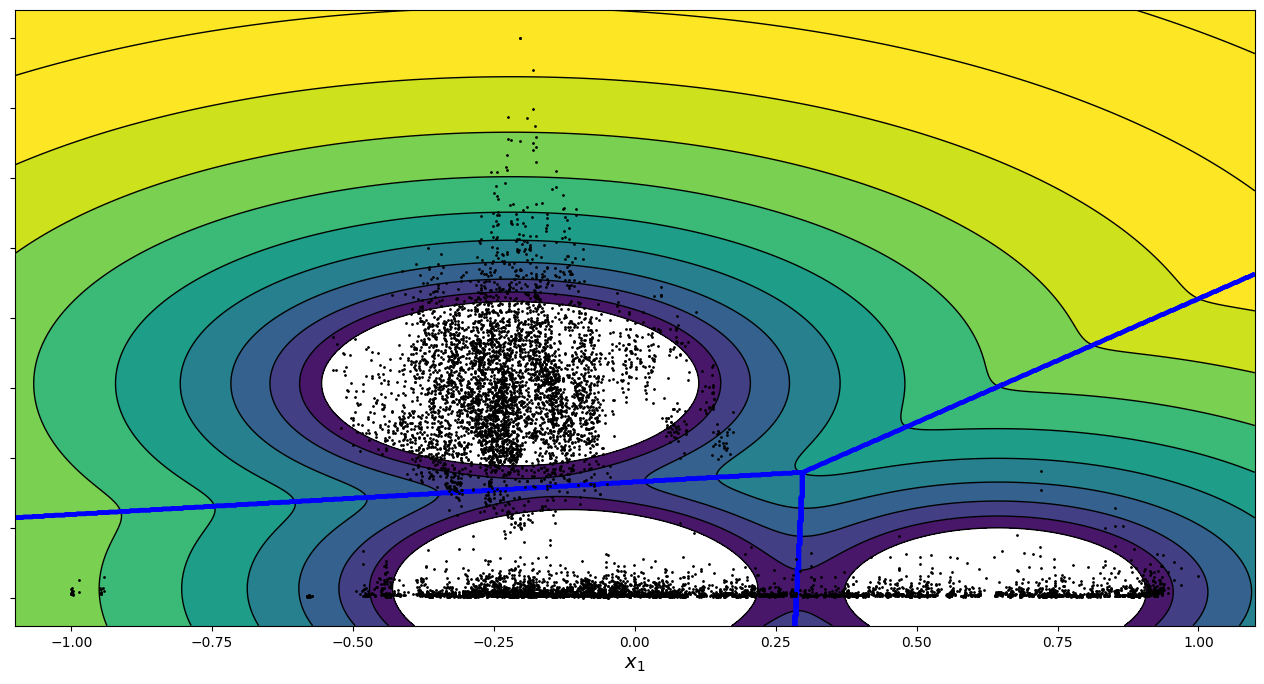

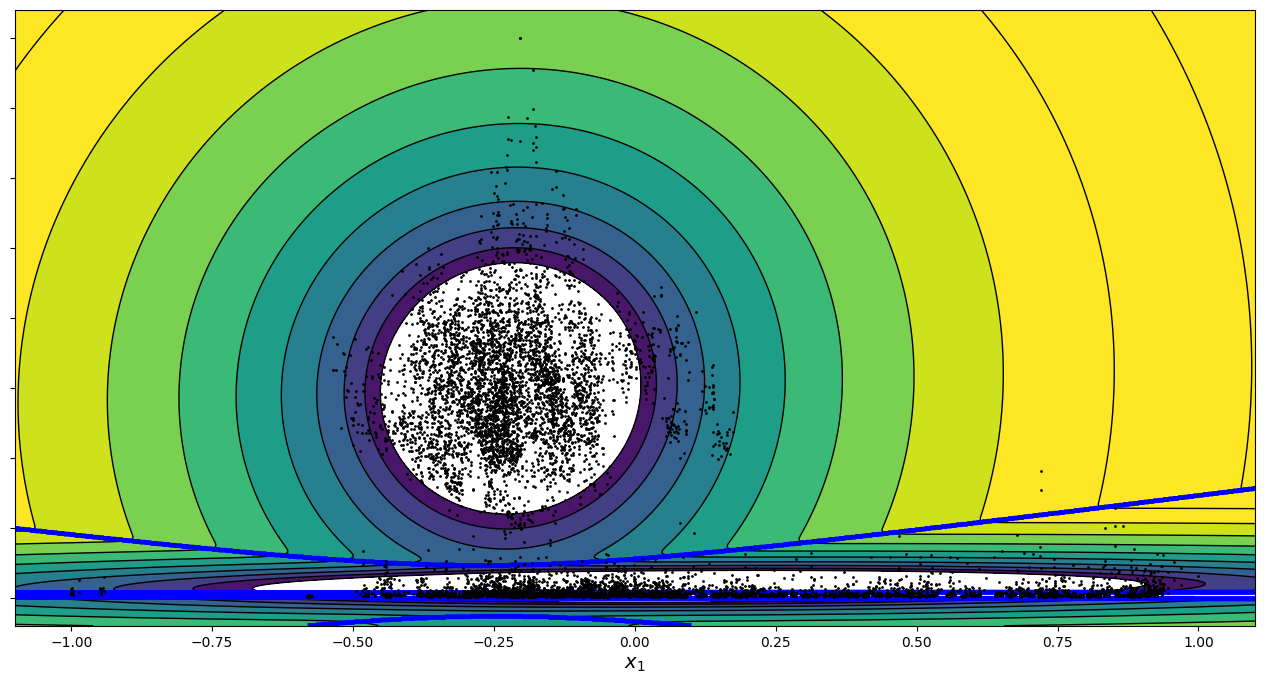

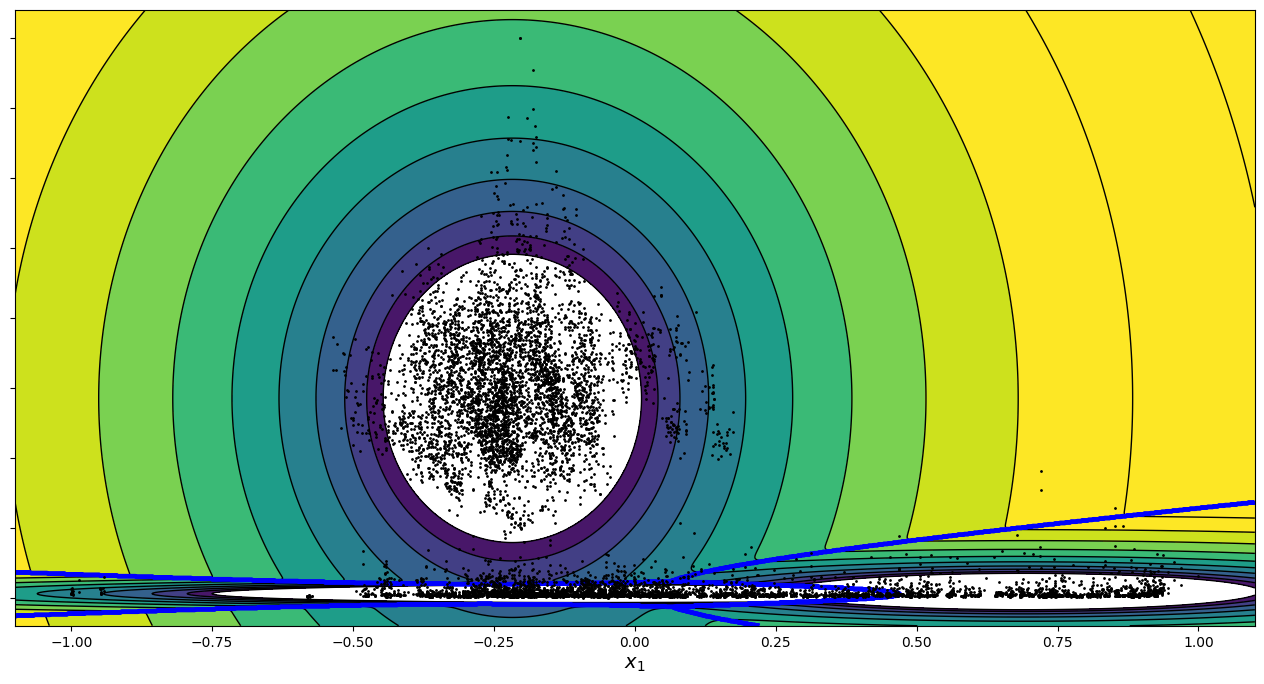

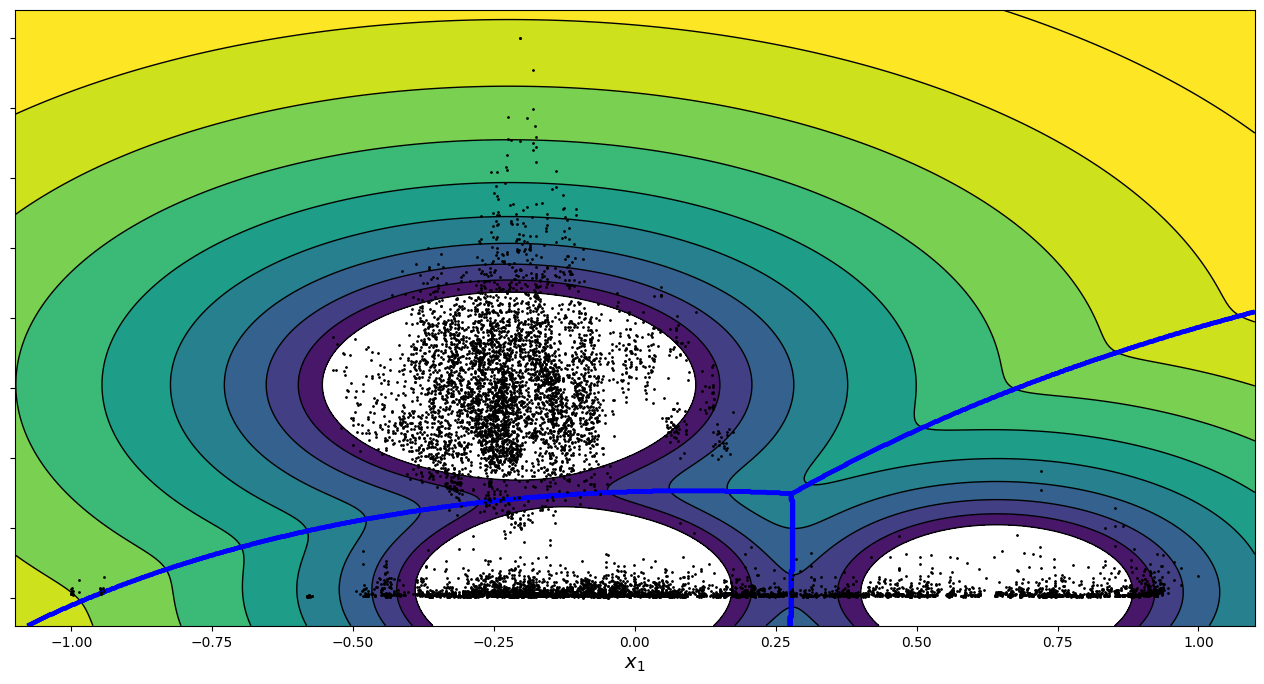

In [62]:
plt.figure(figsize=(16, 8))
plot_gaussian_mixture(gm, X)

plt.figure(figsize=(16, 8))
plot_gaussian_mixture(gm_2, X)


plt.figure(figsize=(16, 8))
plot_gaussian_mixture(gm_3, X)


plt.figure(figsize=(16, 8))
plot_gaussian_mixture(gm_4, X)

plt.show()

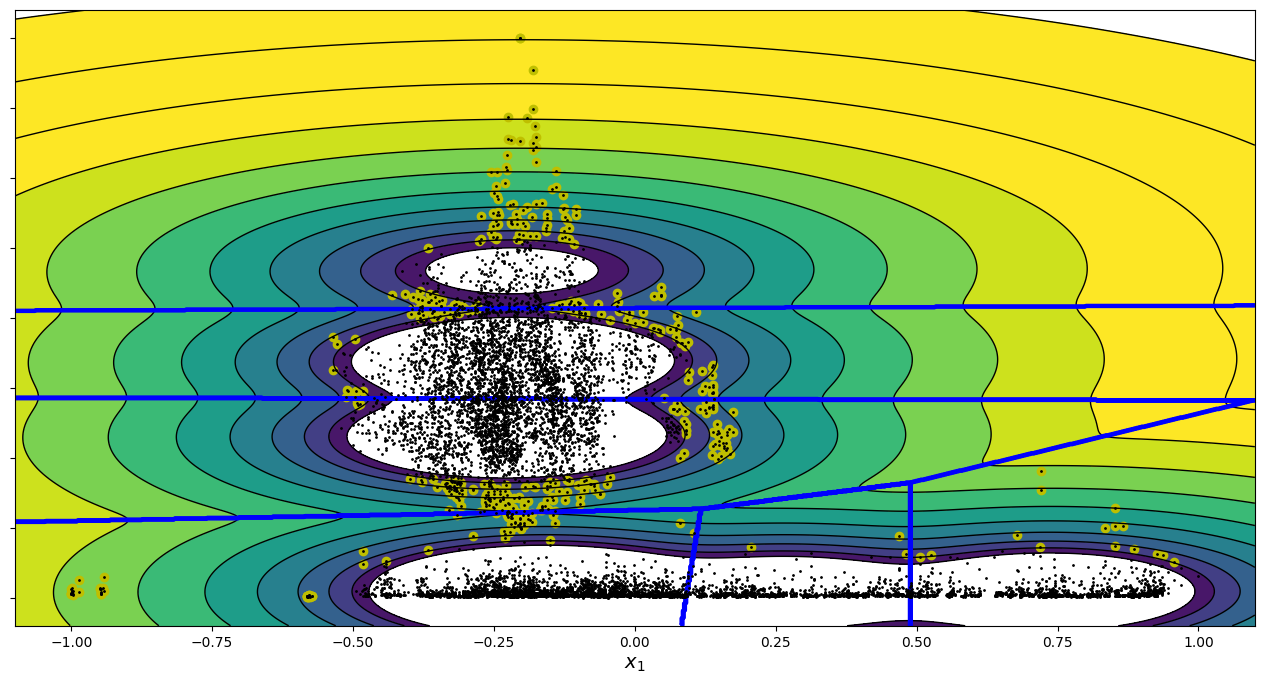

In [63]:
#odsiewanie anomalii
# rysujemy wykres jak poprzednio
gm = GaussianMixture(n_components=6, n_init=10, random_state=42,covariance_type="tied")
gm.fit(X)

plt.figure(figsize=(16, 8))

plot_gaussian_mixture(gm, X)

# Pobieramy wartości dla naszego zbioru, które
# mówią nam, jak bardzo element należy do klastrów
density = gm.score_samples(X)
# Tworzymy wartość graniczną, czyli threshold. Wartości,
# które mają wyniki z poprzedniej linii mniejsze od naszego
# threshold, są anomaliami, więc zostają odsiane

# W naszym przypadku chcemy odsiać 5% najgorszych wartości
threshold = np.percentile(density, 5)

# Odsiewamy te wartości poprzez proste porównanie
anomalie = X[density < threshold]

plt.scatter(anomalie[:, 0], anomalie[:, 1], color='y', marker='o')
plt.show()

In [64]:
Unsupervised learning działa słabo. Klasy, do których dążymy sa zbyt mało od siebie odseparowane. Na podstawie KMeans i Silhouette score można uznać, że najlepiej jest, aby były 3 klastry. Sęk w tym, że potrzebujemy ich 6.

Czym różni się KMeans, K-fold i K Nearest Neighbors: KMeans - algorytm, który znajduje zadaną ilość klastrów; K-fold - narzędzie służące do przeprowadzenia weryfikacji krzyżowej czyli crossvalidation; K Nearest Neighbors - klasyfikator opierający się na algorytmie k najbliższych sąsiadów

SyntaxError: invalid syntax (3415827327.py, line 1)